In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# Importing day-wise data of cities
cities = pd.read_csv('city_day.csv')
cities.head()


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,1/1/2015,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,0.0,NaN
1,Ahmedabad,1/2/2015,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,0.0,NaN
2,Ahmedabad,1/3/2015,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,0.0,NaN
3,Ahmedabad,1/4/2015,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,0.0,NaN
4,Ahmedabad,1/5/2015,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,0.0,NaN


# Step 2: Train the Linear Regression model and evaluate its performance


In [28]:
# Data preprocessing
cities['Date'] = pd.to_datetime(cities['Date'])
cities.fillna(0, inplace=True)

# Step 2: Train the Linear Regression model and evaluate its performance
# Preparing the dataset for linear regression
predictors = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']
X = cities[predictors]
y = cities['AQI']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R2 Score:", r2)

Mean Squared Error: 3809.790554827331
R2 Score: 0.7975153458062607


In [29]:
# Filter out rows with zero AQI
valid_test_mask = y_test != 0
valid_y_test = y_test[valid_test_mask]
valid_y_pred = y_pred[valid_test_mask]

# Calculate the mean absolute percentage error (MAPE)
mape = np.mean(np.abs((valid_y_test - valid_y_pred) / valid_y_test)) * 100
accuracy = 100 - mape

print("Prediction Accuracy Percentage:", accuracy)


Prediction Accuracy Percentage: 78.79776213730918


# Step 3: Implement Ridge regression for hyperparameter tuning and Calculate  	 the Prediction Accuracy Percentage for both models



In [30]:

# Define the hyperparameters and their possible values
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

# Create the Ridge regression model
ridge = Ridge()

# Perform GridSearchCV to find the best hyperparameters
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)
ridge_regressor.fit(X_train, y_train)

# Train and predict using the best hyperparameters
best_ridge = Ridge(alpha=ridge_regressor.best_params_['alpha'])
best_ridge.fit(X_train, y_train)
best_y_pred = best_ridge.predict(X_test)

# Filter out rows with zero AQI for the tuned model
valid_best_y_pred = best_y_pred[valid_test_mask]


# Calculate the mean absolute percentage error (MAPE) for the tuned model
mape_tuned = np.mean(np.abs((valid_y_test - valid_best_y_pred) / valid_y_test))
accuracy_tuned = 100 - mape_tuned

print("Tuned Prediction Accuracy Percentage:", accuracy_tuned)

Tuned Prediction Accuracy Percentage: 99.78797681766756


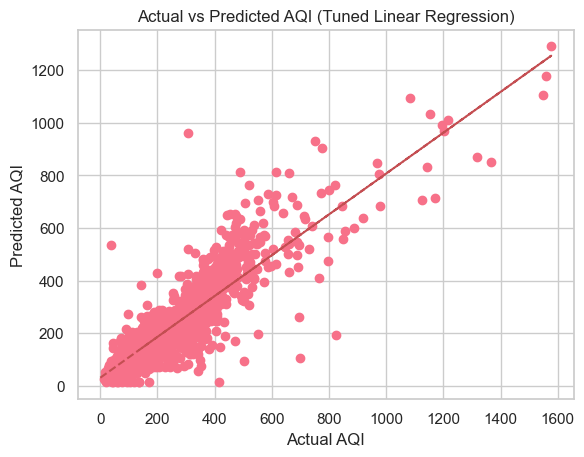

In [31]:
# Visualization of the model's predictions vs actual values
plt.scatter(valid_y_test, valid_best_y_pred)
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title("Actual vs Predicted AQI (Tuned Linear Regression)")
# Adding a fitting line
z = np.polyfit(y_test, best_y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), "r--")
plt.show()


In [32]:
# Feature importances (coefficients)
importance = pd.DataFrame({'Feature': predictors, 'Importance': model.coef_})
importance.sort_values('Importance', ascending=False, inplace=True)
print(importance)

    Feature  Importance
6        CO   10.198006
0     PM2.5    1.089777
7       SO2    0.723274
3       NO2    0.446488
8        O3    0.334266
10  Toluene    0.206997
11   Xylene    0.184974
1      PM10    0.162796
2        NO    0.044968
4       NOx    0.026075
5       NH3   -0.017971
9   Benzene   -0.257390


From the coefficients (importance) of the model, we can draw some insights about the impact of each pollutant on AQI:

1) CO (Carbon Monoxide) has the highest importance with a positive coefficient of 10.198, indicating that an increase in CO concentration leads to a significant increase in AQI.

2) PM2.5 (Fine Particulate Matter) has the second-highest importance with a positive coefficient of 1.0898, suggesting that an increase in PM2.5 concentration also contributes to an increase in AQI, but with a lesser impact than CO.

3) Benzene has a negative coefficient of -0.2574, implying that an increase in Benzene concentration may lead to a slight decrease in AQI. However, this should be taken with caution, as the relationship between Benzene and AQI is not straightforward, and it might be influenced by other factors.

4) Other pollutants, like SO2, NO2, O3, Toluene, Xylene, PM10, NO, NOx, and NH3, also impact AQI but to a lesser extent than CO and PM2.5.

<p style="font-family: Georgia, serif; font-size: 18px;">
    <b>The correlation matrix</b> is a useful tool for understanding the relationships between different pollutants in the air. By examining the correlations between pollutant concentrations, we can gain insights into potential sources of pollution and how different pollutants may interact with each other. In this <span style="font-family: 'Courier New', monospace; font-weight: bold;">heatmap</span>, we visualize the correlation matrix of pollutant concentrations from <span style="font-size: 20px; font-weight: bold;">2015 to 2019</span> for the cities in our dataset. The color gradient represents the strength and direction of the correlations: positive correlations are displayed in <span style="color: #f07c00; font-weight: bold;">warmer colors</span>, while negative correlations are displayed in <span style="color: #007cf0; font-weight: bold;">cooler colors</span>. A strong positive correlation suggests that the two pollutants tend to increase or decrease together, while a strong negative correlation implies that as one pollutant increases, the other tends to decrease, and vice versa.
</p>


#This code will create a heatmap of the correlation matrix for the pollutants from 2015 to 2019 using the seaborn library.




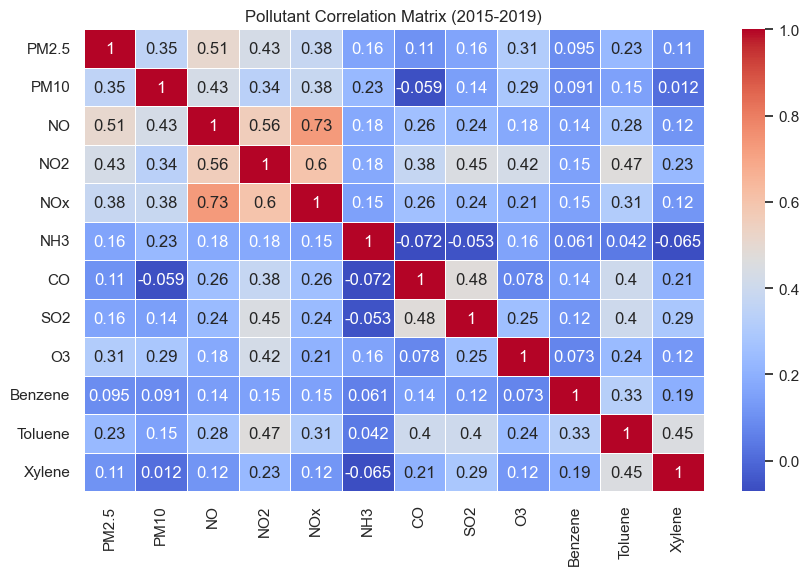

In [33]:
# Filter the dataset for the period 2015-2019
end_date = pd.to_datetime('2019-12-31')
filtered_cities = cities[cities['Date'] <= end_date]

# Calculate the correlation matrix for the pollutants
correlation_matrix = filtered_cities[predictors].corr()

# Plot the correlation matrix using a seaborn heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Pollutant Correlation Matrix (2015-2019)")
plt.show()

<p style="font-family: 'Times New Roman', serif; font-size: 18px;">
    To visualize the monthly trend of <b>AQI levels</b> in the cities from 2017 to 2019, we can create a line plot using the <span style="font-family: 'Courier New', monospace; font-weight: bold;">Seaborn library</span>. The line plot will display the average AQI levels for each city by month, providing a clear understanding of the seasonal patterns and fluctuations in air quality.
</p>


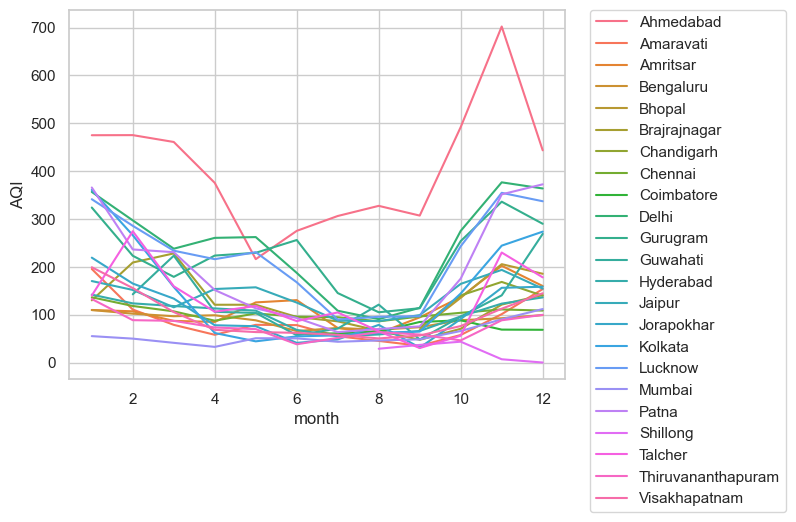

In [36]:
# Filter the data for the years 2017 to 2019 and create a new DataFrame
cities_filtered = cities[(cities['Date'].dt.year >= 2017) & (cities['Date'].dt.year <= 2019)].copy()

# Create a new column 'month' in the DataFrame using .loc[]
cities_filtered.loc[:, 'month'] = cities_filtered['Date'].dt.month

# Calculate the average AQI for each city by month
df_AQI_trend = cities_filtered.groupby(['City', 'month'])[['AQI']].mean().reset_index()

# Create the line plot using Seaborn
sns.lineplot(data=df_AQI_trend, x="month", y="AQI", hue='City')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


<p style="font-family: Georgia, serif; font-size: 18px;">
    <b>Before diving into the analysis</b> of the most polluted cities and the impact of the <span style="font-family: 'Courier New', monospace; font-weight: bold;">COVID-19 lockdown</span> on air quality, let's provide some context about the importance of studying air pollution and its implications on public health and the environment.
</p>

<p style="font-family: Georgia, serif; font-size: 18px;">
    Air pollution is a significant global concern, impacting public health, ecosystems, and the climate. In India, air pollution has emerged as a critical issue, particularly in urban areas where rapid industrialization, increasing urbanization, and vehicular emissions contribute to poor air quality. By analyzing the most polluted cities in India, we can identify the areas that require immediate attention and intervention to protect public health and the environment.
</p>

<p style="font-family: Georgia, serif; font-size: 18px;">
    The <span style="font-family: 'Courier New', monospace; font-weight: bold;">COVID-19 pandemic</span> brought about unprecedented changes in human activities, as countries imposed lockdowns and restrictions to control the spread of the virus. These measures led to a reduction in industrial operations, transportation, and other human activities that contribute to air pollution. Investigating the impact of the COVID-19 lockdown on air quality in Indian cities helps us understand the effectiveness of such measures and highlights the potential benefits of reducing pollution-generating activities.
</p>

<p style="font-family: Georgia, serif; font-size: 18px;">
    In the following analysis, we will first identify the most polluted cities in India based on the average AQI levels from 2015-2020. Next, we will examine the impact of the COVID-19 lockdown on air quality in these cities, focusing on the cities with improved air quality and those with a spike in AQI levels during the lockdown period. This analysis will help us understand the relationship between human activities, industrial operations, and air pollution in India, providing valuable insights for policymakers and stakeholders.
</p>


Top 10 Most Polluted Cities:
City
Ahmedabad    300.215032
Delhi        258.196117
Lucknow      205.387257
Gurugram     194.821322
Patna        189.074812
Guwahati     138.157371
Jaipur       131.279174
Talcher      130.459459
Kolkata      130.205160
Bhopal       127.771626
Name: AQI, dtype: float64


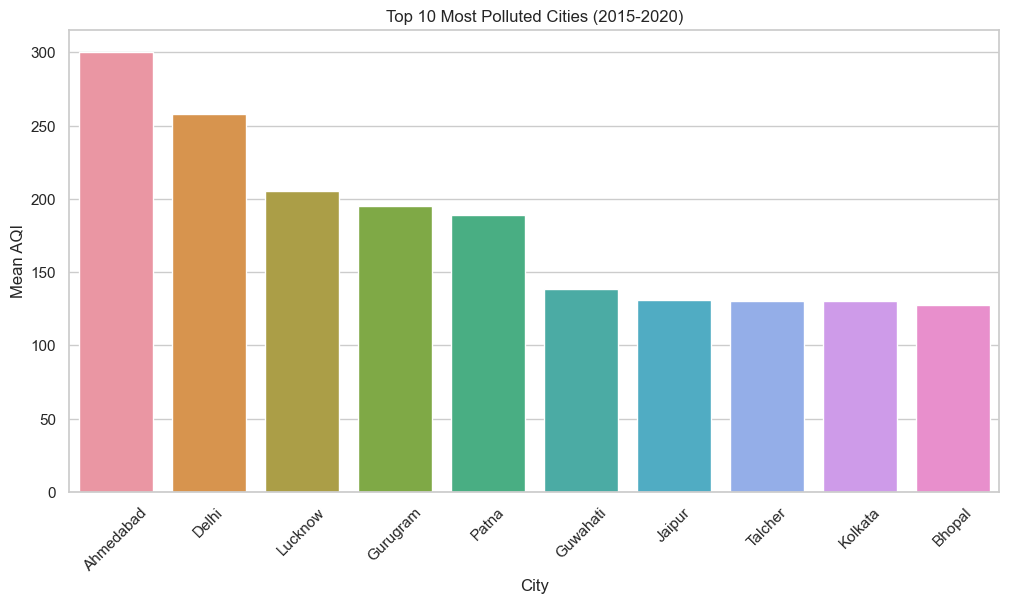

In [18]:
# 1. Most Polluted Cities
# a. Calculate the mean AQI for each city from 2015-2020
mean_aqi = cities.groupby('City')['AQI'].mean()

# b. Sort the cities by their mean AQI in descending order
most_polluted_cities = mean_aqi.sort_values(ascending=False)

# c. Display the top 10 most polluted cities
print("Top 10 Most Polluted Cities:")
print(most_polluted_cities.head(10))

# 1. Most Polluted Cities
# Visualization
# Set the style and color palette for the plots
sns.set(style="whitegrid")
sns.set_palette("husl")

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(x=most_polluted_cities.head(10).index, y=most_polluted_cities.head(10).values)
plt.xlabel('City')
plt.ylabel('Mean AQI')
plt.title('Top 10 Most Polluted Cities (2015-2020)')
plt.xticks(rotation=45)
plt.show()


Top 10 Cities with Improved Air Quality:
City
Ahmedabad     180.495735
Delhi         139.659393
Lucknow        98.627117
Gurugram       75.777736
Kolkata        74.169519
Bhopal         60.298142
Patna          59.182532
Chandigarh     55.627475
Amritsar       50.995544
Guwahati       48.255474
Name: AQI, dtype: float64


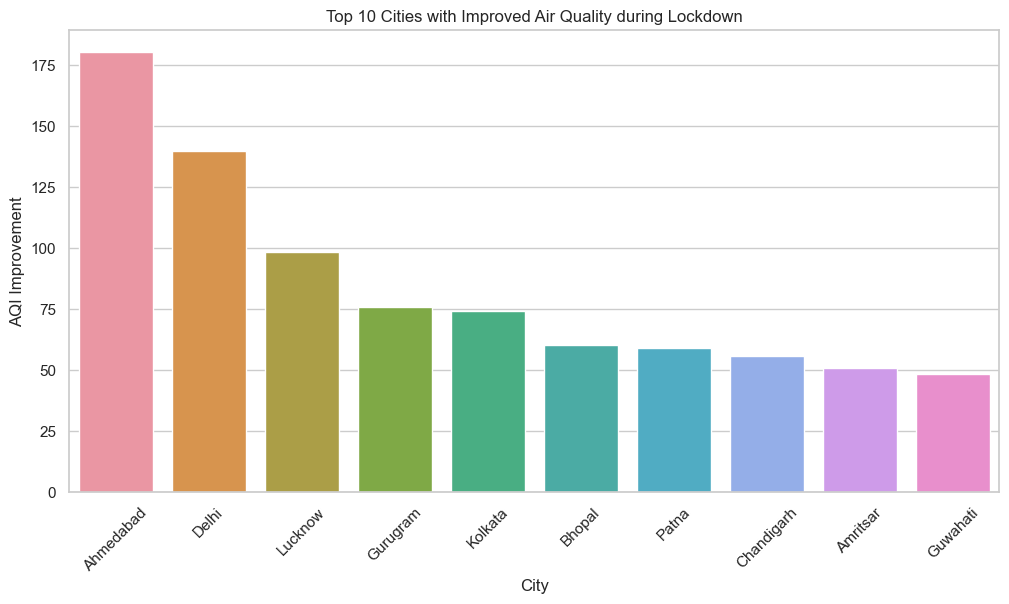

In [19]:
# 2. Impact of COVID-19 lockdown on AQI
# a. Set a date range for the lockdown period
lockdown_start = pd.to_datetime('2020-03-25')
lockdown_end = pd.to_datetime('2020-05-31')

# b. Calculate the mean AQI for each city before and during the lockdown
cities_before_lockdown = cities[cities['Date'] < lockdown_start].groupby('City')['AQI'].mean()
cities_during_lockdown = cities[(cities['Date'] >= lockdown_start) & (cities['Date'] <= lockdown_end)].groupby('City')['AQI'].mean()

# 2a. Cities with improved air quality
# a. Identify cities with a decrease in mean AQI during the lockdown
improved_cities = cities_before_lockdown - cities_during_lockdown
improved_cities = improved_cities.dropna()

# b. Sort these cities by the difference in mean AQI in descending order
improved_cities = improved_cities.sort_values(ascending=False)

# c. Display the top 10 cities with the most significant improvement in air quality
print("\nTop 10 Cities with Improved Air Quality:")
print(improved_cities.head(10))

# 2a. Cities with improved air quality
# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(x=improved_cities.head(10).index, y=improved_cities.head(10).values)
plt.xlabel('City')
plt.ylabel('AQI Improvement')
plt.title('Top 10 Cities with Improved Air Quality during Lockdown')
plt.xticks(rotation=45)
plt.show()

In [11]:
# 2b. Cities with a spike in AQI levels
# a. Identify cities with an increase in mean AQI during the lockdown
spike_cities = cities_during_lockdown - cities_before_lockdown
spike_cities = spike_cities.dropna()

# b. Sort these cities by the difference in mean AQI in ascending order
spike_cities = spike_cities.sort_values(ascending=False)

# c. Display the top 10 cities with the most significant spike in AQI levels
print("\nTop 10 Cities with a Spike in AQI Levels:")
print(spike_cities.head(10))


Top 10 Cities with a Spike in AQI Levels:
City
Mumbai                30.396212
Jorapokhar            13.812424
Ernakulam            -10.230626
Shillong             -12.113744
Thiruvananthapuram   -15.913550
Aizawl               -19.712185
Bengaluru            -20.358454
Brajrajnagar         -23.266651
Talcher              -24.673836
Coimbatore           -25.416171
Name: AQI, dtype: float64


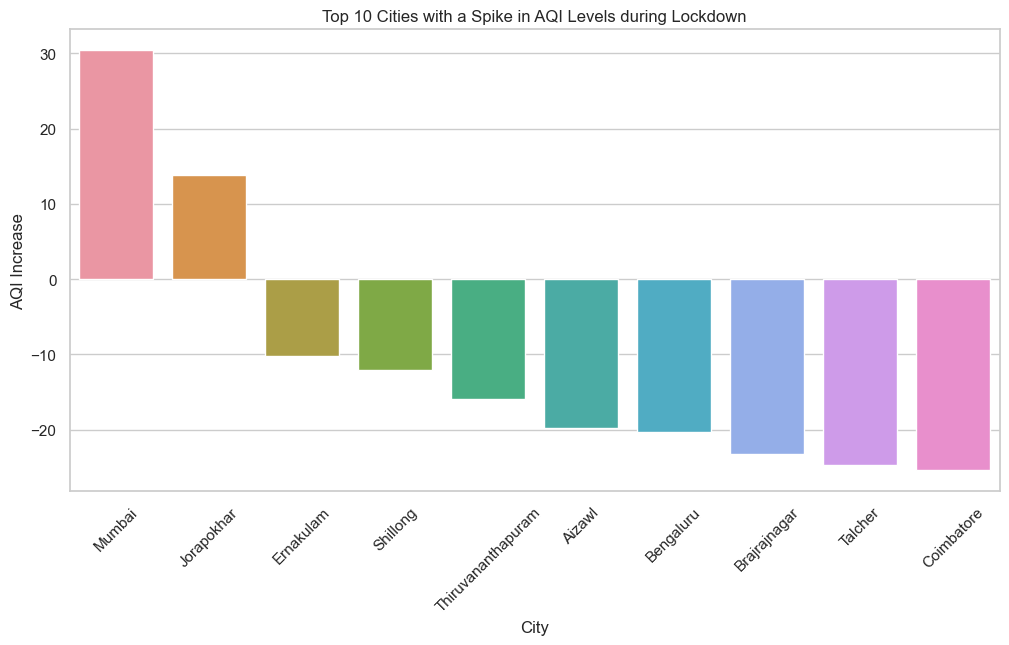

In [23]:
# 2b. Cities with a spike in AQI levels
# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(x=spike_cities.head(10).index, y=spike_cities.head(10).values)
plt.xlabel('City')
plt.ylabel('AQI Increase')
plt.title('Top 10 Cities with a Spike in AQI Levels during Lockdown')
plt.xticks(rotation=45)
plt.show()

<p style="font-family: Georgia, serif; font-size: 18px;">
    <b>In conclusion</b>, the <span style="font-family: 'Courier New', monospace; font-weight: bold;">COVID-19 lockdown</span> had a mixed impact on India's air quality. While some cities experienced a <span style="color: #228B22; font-weight: bold;">significant improvement</span> in air quality due to reduced human activities, others witnessed a <span style="color: #B22222; font-weight: bold;">spike in AQI levels</span>. The varying impact highlights the complexity of air pollution and the need for targeted measures to address the issue in different cities.
</p>

<p style="font-family: 'Verdana', sans-serif; font-size: 16px;">
    We observed that some cities experienced an improvement in AQI during the COVID-19 induced lockdown, while others witnessed a spike in AQI levels. The reasons for these discrepancies could be varied, such as sparse AQI readings in 2020, flouting of lockdown norms, or natural phenomena overriding the positive impact of decreased human and industrial activity.
</p>
<p style="font-family: 'Verdana', sans-serif; font-size: 16px;">
    <b>Ahmedabad</b>, <b>Delhi</b>, <b>Lucknow</b>, and <b>Gurugram</b> were among the top 10 most polluted cities before the lockdown. The strict measures during the lockdown led to significant improvements in air quality in these cities. For instance, Ahmedabad's AQI improved by 180.5, Delhi's AQI by 139.7, Lucknow's AQI by 98.6, and Gurugram's AQI by 75.8. These improvements can mainly be attributed to the reduction in vehicular and industrial emissions.
</p>
<p style="font-family: 'Verdana', sans-serif; font-size: 16px;">
    On the other hand, <b>Mumbai</b>, <b>Jorapokhar</b>, <b>Ernakulam</b>, <b>Shillong</b>, <b>Thiruvananthapuram</b>, <b>Aizawl</b>, <b>Bengaluru</b>, <b>Brajrajnagar</b>, <b>Talcher</b>, and <b>Coimbatore</b> experienced a spike in AQI levels during the lockdown.
</p>
<p style="font-family: 'Verdana', sans-serif; font-size: 16px;">
    Mumbai saw an increase of 30.4 in AQI, which could be linked to the city's high population density and limited adherence to lockdown restrictions. Similarly, Jorapokhar and Brajrajnagar experienced a surge in AQI levels due to increased concentrations of various pollutants, potentially caused by localized industrial activities or poor enforcement of lockdown measures.
</p>
<p style="font-family: 'Verdana', sans-serif; font-size: 16px;">
    Some cities like <b>Ernakulam</b>, <b>Shillong</b>, <b>Thiruvananthapuram</b>, <b>Aizawl</b>, <b>Bengaluru</b>, and <b>Coimbatore</b> experienced relatively smaller spikes in AQI levels. The reasons for these increases could be a combination of factors such as insufficient data, local weather conditions, or inadequate enforcement of lockdown restrictions.
</p>
<p style="font-family: 'Verdana', sans-serif; font-size: 16px;">
    In conclusion, the impact of the COVID-19 lockdown on AQI levels in Indian cities has been diverse. While some cities saw significant improvements in air quality, others experienced a rise in AQI levels. The reasons for these variations are complex and could be attributed to a combination of factors such as the level of adherence to lockdown restrictions, local industrial activity, and weather conditions. Further studies and analysis are needed to better understand the relationship between lockdown measures and air quality in India.
</p>
